<a href="https://colab.research.google.com/github/CansecoSergio/python-data-science/blob/main/FR_M11_SergioCanseco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalación de paquetes y librerías

In [73]:
!pip install -U pysentimiento

In [74]:
!pip install dash #dependencia para instalar dash

In [165]:
import pandas as pd
import numpy as np
import regex as re
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
import plotly.express as px
import dash_html_components as html
from nltk.corpus import stopwords
from itertools import islice
from wordcloud import WordCloud
from PIL import Image
from pysentimiento import create_analyzer
from sklearn.manifold import TSNE
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from dash.dependencies import ClientsideFunction, Output, Input
from dash import Dash, html, dash_table,dcc

In [111]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Obtención de información del archivo

In [77]:
stock_df = pd.read_csv('/content/drive/MyDrive/Archivos Collab/M11/stockerbot-export.csv', on_bad_lines='skip')

In [78]:
stock_df.head()

,id,text,timestamp,source,symbols,company_names,url,verified
0,1019696670777503700,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1019709091038548000,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1019711413798035500,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1019716662587740200,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1019718460287389700,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


### Preparación y creación del Corpus

**Exploración de información y cálculo de frecuencias**

In [107]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28264 entries, 0 to 28263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             28264 non-null  int64 
 1   text           28264 non-null  object
 2   timestamp      28264 non-null  object
 3   source         28264 non-null  object
 4   symbols        28264 non-null  object
 5   company_names  28263 non-null  object
 6   url            21895 non-null  object
 7   verified       28264 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 1.5+ MB


In [109]:
stock_df.shape

(28264, 8)

In [79]:
#Revisión de valores nulos
stock_df.isna().sum()

,0
id,0
text,0
timestamp,0
source,0
symbols,0
company_names,1
url,6369
verified,0


In [80]:
#Eliminación de las columnas que no serán parte del corpus por analizar
stock_df_clean = stock_df.drop(columns=['id', 'timestamp', 'source', 'symbols', 'company_names', 'url', 'verified'], axis=1)
stock_df_clean.head()

,text
0,VIDEO: “I was in my office. I was minding my o...
1,The price of lumber $LB_F is down 22% since hi...
2,Who says the American Dream is dead? https://t...
3,Barry Silbert is extremely optimistic on bitco...
4,How satellites avoid attacks and space junk wh...


**Frecuencia de longitudes**

In [126]:
size_df = stock_df_clean

In [127]:
size_df['longitud'] = size_df['text'].str.len()

In [129]:
size_df[['text', 'longitud']].head()

,text,longitud
0,VIDEO: “I was in my office. I was minding my o...,140
1,The price of lumber $LB_F is down 22% since hi...,136
2,Who says the American Dream is dead? https://t...,60
3,Barry Silbert is extremely optimistic on bitco...,140
4,How satellites avoid attacks and space junk wh...,130


### Procesamiento Básico del corpus

**Definición de funciones para procesamiento**

In [81]:
def quita_puntuacion(texto):
    traductor = str.maketrans(str.maketrans('','', string.punctuation))
    return texto.translate(traductor)

In [82]:
def tokenizador(texto):
    return re.findall("[\w-]+\p{L}[\w-]+", texto)

In [83]:
def quita_sw(vpalabras, idioma= "english"):
    return [ palabra for palabra in vpalabras if palabra not in stopwords.words(idioma) ]

In [84]:
#Se agrega función especial para remover todos los links que se encuentran en los tuits.
def quita_uris(vpalabras):
    return [ palabra for palabra in vpalabras if not palabra.startswith('https') ]

In [85]:
def preprocesa_texto(texto, funciones):
  str_texto = texto.strip()
  for funcion in funciones:
    str_texto = funcion(str_texto)
  return str_texto
fn = [str.lower, quita_puntuacion, tokenizador, quita_sw, quita_uris]
fn_con_stopwords = [str.lower, quita_puntuacion, tokenizador, quita_uris]

In [86]:
stock_df_clean["tokens_sin_stopwords"] = stock_df_clean["text"].apply(preprocesa_texto, funciones=fn)
stock_df_clean["tokens_con_stopwords"] = stock_df_clean["text"].apply(preprocesa_texto, funciones=fn_con_stopwords)
stock_df_clean.head()

,text,tokens_sin_stopwords,tokens_con_stopwords
0,VIDEO: “I was in my office. I was minding my o...,"[video, office, minding, business, david, solo...","[video, was, office, was, minding, own, busine..."
1,The price of lumber $LB_F is down 22% since hi...,"[price, lumber, lbf, since, hitting, ytd, high...","[the, price, lumber, lbf, down, since, hitting..."
2,Who says the American Dream is dead? https://t...,"[says, american, dream, dead]","[who, says, the, american, dream, dead]"
3,Barry Silbert is extremely optimistic on bitco...,"[barry, silbert, extremely, optimistic, bitcoi...","[barry, silbert, extremely, optimistic, bitcoi..."
4,How satellites avoid attacks and space junk wh...,"[satellites, avoid, attacks, space, junk, circ...","[how, satellites, avoid, attacks, and, space, ..."


**Frecuencia de palabras**

In [181]:
#Contar cuanto se repite cada palabra en el documento.
diccionario = {}
for registro in stock_df_clean.tokens_sin_stopwords:
  for palabra in registro:
    if palabra in diccionario:
      diccionario[palabra] += 1
    else:
      diccionario[palabra] = 1
print(diccionario)

{'video': 118, 'office': 48, 'minding': 1, 'business': 80, 'david': 34, 'solomon': 1, 'tells': 19, 'interns': 1, 'learned': 2, 'price': 1766, 'lumber': 16, 'lbf': 9, 'since': 110, 'hitting': 21, 'ytd': 16, 'highs': 128, 'macys': 11, 'turnaround': 17, 'still': 156, 'happening': 12, 'says': 127, 'american': 169, 'dream': 2, 'dead': 12, 'barry': 9, 'silbert': 2, 'extremely': 15, 'optimistic': 6, 'bitcoin': 205, 'predicts': 2, 'new': 1203, 'crypto': 436, 'entrants': 1, 'going': 135, 'zero': 6, 'satellites': 1, 'avoid': 20, 'attacks': 5, 'space': 83, 'junk': 1, 'circling': 4, 'earth': 2, 'paid': 278, 'oracle': 2, 'realmoneys': 2, 'butlers': 2, 'favorite': 13, 'fang': 58, 'stock': 1822, 'isnt': 16, 'realmoneysod': 15, 'alphabet': 28, 'facebook': 24, 'miss': 96, 'convo': 1, 'one': 450, 'thinkers': 1, 'samharrisorg': 1, 'intelligence': 8, 'documents': 5, 'nelson': 5, 'mandela': 1, 'made': 194, 'public': 113, 'senate': 15, 'wants': 28, 'emergency': 2, 'alerts': 486, 'netflix': 63, 'spotify': 2,

**Integración de PySentimiento**

In [90]:
sentimientos = create_analyzer(task="sentiment", lang="en")

In [91]:
def analiza_sentimientos(texto):
    prediccion = sentimientos.predict(texto)
    return prediccion.output

In [95]:
stock_df_clean["sentimientos"] = stock_df_clean["text"].apply(analiza_sentimientos)
stock_df_clean.head()

,text,tokens_sin_stopwords,tokens_con_stopwords,sentimientos
0,VIDEO: “I was in my office. I was minding my o...,"[video, office, minding, business, david, solo...","[video, was, office, was, minding, own, busine...",NEU
1,The price of lumber $LB_F is down 22% since hi...,"[price, lumber, lbf, since, hitting, ytd, high...","[the, price, lumber, lbf, down, since, hitting...",NEU
2,Who says the American Dream is dead? https://t...,"[says, american, dream, dead]","[who, says, the, american, dream, dead]",NEG
3,Barry Silbert is extremely optimistic on bitco...,"[barry, silbert, extremely, optimistic, bitcoi...","[barry, silbert, extremely, optimistic, bitcoi...",NEU
4,How satellites avoid attacks and space junk wh...,"[satellites, avoid, attacks, space, junk, circ...","[how, satellites, avoid, attacks, and, space, ...",NEU


In [102]:
stock_df_clean[['text', 'sentimientos']].groupby('sentimientos').count()

,text
sentimientos,
NEG,1377
NEU,22701
POS,4186


Análisis del procentaje de sentimientos

In [179]:
negativos = stock_df_clean[stock_df_clean['sentimientos'] == 'NEG'].shape[0]
positivos = stock_df_clean[stock_df_clean['sentimientos'] == 'POS'].shape[0]
neutros = stock_df_clean[stock_df_clean['sentimientos'] == 'NEU'].shape[0]

total = stock_df_clean.shape[0]

print('negativos : ', negativos/total)
print('positivos : ', positivos/total)
print('neutros : ', neutros/total)

negativos :  0.04871921879422587
positivos :  0.1481035946787433
neutros :  0.8031771865270309


**Integración de T-SNE**

In [114]:
modelow2v  = word2vec.Word2Vec(stock_df_clean.tokens_sin_stopwords.to_list(), vector_size=100, window=5, min_count=2, workers=4)

In [115]:
vocabulario = modelow2v.wv.key_to_index

In [116]:
print(vocabulario)

{'inc': 0, 'amp': 1, 'earnings': 2, 'stock': 3, 'price': 4, 'analysts': 5, 'eps': 6, 'new': 7, 'group': 8, 'expected': 9, 'binance': 10, 'buy': 11, 'stocks': 12, 'short': 13, 'register': 14, 'bonus': 15, 'million': 16, 'join': 17, 'today': 18, 'options': 19, 'high': 20, 'rating': 21, 'target': 22, 'trading': 23, 'share': 24, 'shares': 25, 'investment': 26, 'energy': 27, 'get': 28, 'jul': 29, 'corp': 30, 'zacks': 31, 'week': 32, 'see': 33, 'top': 34, 'nflx': 35, 'research': 36, 'financial': 37, 'maxpain': 38, 'interest': 39, 'sales': 40, 'management': 41, 'trade': 42, 'corporation': 43, 'per': 44, 'capital': 45, 'hold': 46, 'market': 47, 'bullish': 48, 'position': 49, 'amzn': 50, 'post': 51, 'filing': 52, 'volume': 53, 'llc': 54, 'holding': 55, 'company': 56, 'quarterly': 57, 'oil': 58, 'international': 59, 'alerts': 60, 'news': 61, 'spy': 62, 'stake': 63, 'one': 64, 'ibm': 65, 'crypto': 66, 'msft': 67, 'open': 68, 'quarter': 69, 'sell': 70, 'last': 71, 'insider': 72, 'declined': 73, 'a

Búsqueda de relación de la palabra finance

In [117]:
modelow2v.wv["finance"]

array([-0.37415215,  0.13986026, -0.14306548, -0.05727934, -0.17374073,
       -0.40905318,  0.08540621,  0.36412108, -0.21039347, -0.0855421 ,
       -0.16371998, -0.38506198, -0.07040107,  0.12430232,  0.23671624,
       -0.3203199 , -0.05940558, -0.24392226, -0.02139066, -0.60445654,
        0.34478262,  0.24296418,  0.15665205, -0.05866371,  0.07755863,
        0.15581588, -0.5505971 , -0.23453029, -0.3508606 ,  0.08236228,
        0.27873695,  0.09740558,  0.04616319, -0.1806885 ,  0.04796174,
        0.3101953 , -0.10062357,  0.03812575,  0.08383317, -0.47007832,
       -0.0322536 , -0.22683743,  0.03747837, -0.0219298 ,  0.2084915 ,
       -0.1955039 , -0.32192785,  0.11607776,  0.239203  ,  0.1854522 ,
        0.04034641, -0.00809185, -0.06505811,  0.1297284 , -0.20040534,
        0.24434882,  0.17666455, -0.09906776, -0.10444472, -0.12651847,
        0.09548394,  0.2617889 ,  0.01251344,  0.06234741, -0.15671459,
        0.16457179, -0.11295201,  0.1768564 , -0.46497667,  0.35

In [118]:
modelow2v.wv.most_similar("finance")

[('update', 0.9862851500511169),
 ('gregroumeliotis', 0.9842712879180908),
 ('sources', 0.982435405254364),
 ('folks', 0.981957733631134),
 ('arry', 0.9813897609710693),
 ('paris', 0.9812906384468079),
 ('unexpectedly', 0.980986475944519),
 ('jim', 0.9803577065467834),
 ('beneteau', 0.9803377389907837),
 ('strategy', 0.9801858067512512)]

In [121]:
etiquetas = []
tokens = []
# agregar el vocabulario y configurar t-SNE
vocab =modelow2v.wv.key_to_index

for palabra in vocab.items():
    tokens.append(modelow2v.wv[palabra[0]])
    etiquetas.append(palabra[0])

tsne_modelo = TSNE( n_components= 2, perplexity=30, n_iter=300, verbose=1)

#AJUSTE: convertir la matriz de listas python a una estructura en numpy.
datos_entrenamiento = np.array(tokens)
nuevos_valores = tsne_modelo.fit_transform(datos_entrenamiento)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12705 samples in 0.002s...
[t-SNE] Computed neighbors for 12705 samples in 7.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12705
[t-SNE] Computed conditional probabilities for sample 2000 / 12705
[t-SNE] Computed conditional probabilities for sample 3000 / 12705
[t-SNE] Computed conditional probabilities for sample 4000 / 12705
[t-SNE] Computed conditional probabilities for sample 5000 / 12705
[t-SNE] Computed conditional probabilities for sample 6000 / 12705
[t-SNE] Computed conditional probabilities for sample 7000 / 12705
[t-SNE] Computed conditional probabilities for sample 8000 / 12705
[t-SNE] Computed conditional probabilities for sample 9000 / 12705
[t-SNE] Computed conditional probabilities for sample 10000 / 12705
[t-SNE] Computed conditional probabilities for sample 11000 / 12705
[t-SNE] Computed conditional probabilities for sample 12000 / 12705
[t-SNE] Computed conditional probabilities for sam

In [122]:
df = pd.DataFrame(nuevos_valores, columns=["x","y"])
df["Word"] = etiquetas

In [123]:
df.head()

,x,y,Word
0,8.771266,6.715797,inc
1,8.992737,4.893366,amp
2,9.293775,6.093272,earnings
3,8.707406,5.402653,stock
4,7.399266,7.464660,price


### Gráficas de Esploración

**Nube de Palabras**

In [147]:
def nube_palabras(corpus, color):
    wordcloud = WordCloud(
        background_color=color,
        max_words=100,
        max_font_size=50,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('on')
    plt.show()

In [97]:
cadena_sin_stop = " ".join(token for vtexto in stock_df_clean.tokens_sin_stopwords for token in vtexto)

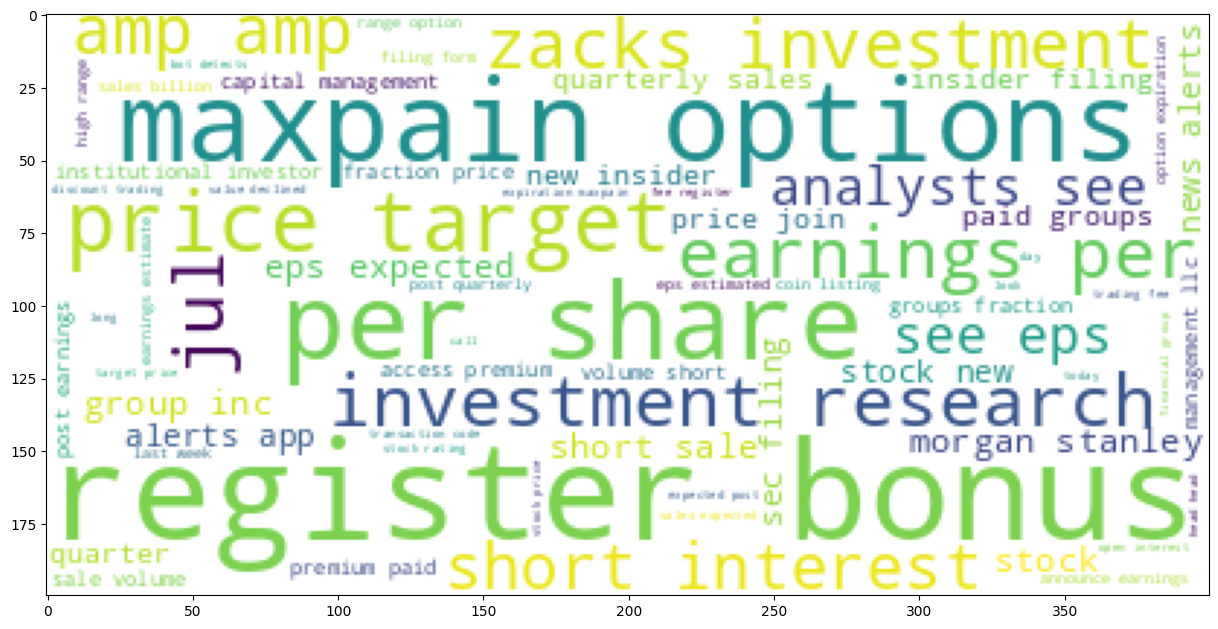

In [148]:
nube_palabras(cadena_sin_stop, color='white')

**Análisis de Sentimientos**

<Axes: xlabel='sentimientos', ylabel='count'>

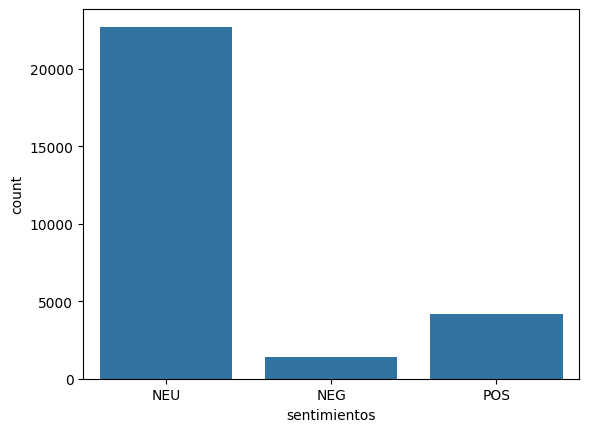

In [105]:
sns.countplot(x='sentimientos', data=stock_df_clean[['text', 'sentimientos']])

**Visualización t-SNE**

In [124]:
fig = px.scatter(df, x='x', y='y', text='Word',
                 title='t-SNE Visualization of Word Embeddings',
                 labels={'text': 'Word'},
                 hover_data=['Word'])

In [125]:
fig.update()

### Dash de exploración

In [150]:
from PIL import Image
import io
import base64

In [154]:
def nube_palabras_img(corpus, color): #función para generar wordcloud, pero guardarla como una imagen.
    wordcloud = WordCloud(
        background_color=color,
        max_words=100,
        max_font_size=45,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))
    img = io.BytesIO()
    wordcloud.to_image().save(img, format='PNG')
    img.seek(0)
    encoded_image = base64.b64encode(img.getvalue()).decode('utf-8')
    return encoded_image

In [155]:
word_cloud_img = nube_palabras_img(cadena_sin_stop, color='white')

In [162]:
value_counts = stock_df_clean.sentimientos.value_counts()
value_counts

,count
sentimientos,
NEU,22701
POS,4186
NEG,1377


In [132]:
app = Dash(__name__)

In [137]:
colors ={
    'backgound':"#111",
    'text': "#333333"
}

In [175]:
#generar datos para dash
app.layout = html.Div([
  html.H1(children="Stocker-bot results", style={'textAlign': 'center', "color": colors["text"]}),

  html.Div([
    html.Div([html.Img(src="data:image/png;base64,{}".format(word_cloud_img))], style={"width": "100%"}),
  ], style={"width": "100%", 'textAlign': 'center'}),

  html.Div([
      html.Div([
          dcc.Graph(figure=px.pie(value_counts, values=value_counts.values, names=value_counts.index, title="Distribución de Sentimientos"))
        ]),
  ]),

  html.Div([
      html.Div([
          dcc.Graph(figure=fig)
        ]),
  ]),

  html.Div([
      dash_table.DataTable(data= stock_df_clean.to_dict("records"), columns=[{"id":cname, "name": cname} for cname in stock_df_clean.columns],
            style_cell={'overflow': 'hidden', 'maxWidth': 0}, page_size=10 )
  ])

])

In [176]:
app.run(jupyter_mode="inline",host="localhost", port=1050)

<IPython.core.display.Javascript object>

### Interpretación de los resultados

De acuerdo a la información obtenida, la cantidad de tuits de sentimiento neutro es mucho mayor a los positivos y negativos, lo que implica que gran parte de ellos son con fines informativos acerca del sector financiero.

Con la información obtenida del wordcloud podemos concluir que en la mayoría de ellos las frecuencias de palabras tales como "bonus", "earnigs" "and price target" representan un actividad ecónomica estable en la bolsa y la ausencia de palabras clave que impliquen perdidas soportan esta idea.
